In [65]:
import pandas as pd
from collections import Counter
import numpy as np

In [ ]:
#Define QID - question matching
qids = ["V201324","V201416", "V202234", "V202257", "V202287", "V202332", "V202337", "V202348", "V202371", "V202378"]
name_dict = {"V201324" : "Current Economy", "V201416" : "Gay Marriage", "V202234" : "Refugee Allowing", 
            "V202257" : "Income Inequality", "V202287" : "Gender Role", "V202332": "Climate Change",
            "V202337": "Gun Regulation", "V202348": "Drug Addiction", "V202371": "Race Diversity", "V202378": "Health Insurance"}

def get_counts(path, qids): #function to get a dict with counts for each question

    value_list = []

    for id in qids:
        df = pd.read_csv(path + id + ".csv")
        df['Response'] = pd.to_numeric(df['Response'], errors='coerce') 

        value_counts = Counter(df['Response'].dropna())

        if id in ["V201324", "V202332"]:

            answers = {i: value_counts[i] for i in range(1, 6)}
        else:
            answers = {i: value_counts[i] for i in range(1, 4)}

        value_list.append({name_dict[id]: answers})

    return value_list


#Get all the results
original_results = get_counts("results/main_mq_results_unzipped/full_results_2020_", qids)
replicate_results = get_counts("MLMM Results/main_mq_results/full_results_2020_", qids)
reformulated_3rdP_results = get_counts("MLMM Results/main_mq_reform_3rdP_results/full_results_2020_", qids)
primed_reformulated_results = get_counts("MLMM Results/Priming/Reformulated/full_results_2020_", qids)
primed_original_results = get_counts("MLMM Results/Priming/Original/full_results_2020_", qids)
preamble_original_results = get_counts("MLMM Results/Preamble/Original/full_results_2020_", qids)

#Only some IDs were used for reverse-coded
qids_reverse_coded = ["V201416", "V202234", "V202257", "V202287", "V202332", "V202371"]
rever_coded_results = get_counts("MLMM Results/main_mq_reverse_3rdP_results/full_results_2020_", qids_reverse_coded)

#get updated Gender Role question
qid_gender = ["V202287"]
updated_gender_role = get_counts("MLMM Results/Altered Prompts/3rdPov/full_results_2020_", qid_gender)


In [67]:
def get_human_counts(path, qids): #getting results from anes 2020

     anes_df = pd.read_csv(path)

     human_values = []

     for id in qids:

          human_counts = Counter(anes_df[id].dropna())

          if id in ["V201324", "V202332"]:

               answers = {i: human_counts[i] for i in range(1, 6)}
          else:
               answers = {i: human_counts[i] for i in range(1, 4)}

          human_values.append({name_dict[id]: answers})

     return human_values

human_results = get_human_counts("data/2020 ANES_test.csv", qids)

C:\Users\msmir\AppData\Local\Temp\ipykernel_10220\4095551727.py:3: DtypeWarning: Columns (19,21,22,23,25,26,27,29,30,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  anes_df = pd.read_csv(path)


In [68]:
#Recoding reverse-coded questions
from copy import deepcopy 

rever_coded_results = {list(d.keys())[0]: list(d.values())[0] for d in rever_coded_results}
rever_coded_results_copy = deepcopy(rever_coded_results)

rever_coded_results["Gay Marriage"][1] = rever_coded_results_copy["Gay Marriage"][3]
rever_coded_results["Gay Marriage"][3] = rever_coded_results_copy["Gay Marriage"][1]

rever_coded_results["Refugee Allowing"][1] = rever_coded_results_copy["Refugee Allowing"][2]
rever_coded_results["Refugee Allowing"][2] = rever_coded_results_copy["Refugee Allowing"][1]

rever_coded_results["Income Inequality"][1] = rever_coded_results_copy["Income Inequality"][2]
rever_coded_results["Income Inequality"][2] = rever_coded_results_copy["Income Inequality"][1]

rever_coded_results["Gender Role"][1] = rever_coded_results_copy["Gender Role"][2]
rever_coded_results["Gender Role"][2] = rever_coded_results_copy["Gender Role"][1]

rever_coded_results["Climate Change"][1] = rever_coded_results_copy["Climate Change"][5]
rever_coded_results["Climate Change"][2] = rever_coded_results_copy["Climate Change"][4]
rever_coded_results["Climate Change"][4] = rever_coded_results_copy["Climate Change"][2]
rever_coded_results["Climate Change"][5] = rever_coded_results_copy["Climate Change"][1]

rever_coded_results["Race Diversity"][1] = rever_coded_results_copy["Race Diversity"][2]
rever_coded_results["Race Diversity"][2] = rever_coded_results_copy["Race Diversity"][1]

rever_coded_results = [{key: value} for key, value in rever_coded_results.items()]

In [ ]:
from scipy.stats import entropy  # entropy is a function to compute KL-divergence

def kl_divergence_between_sets(set1, set2):

    kl_results = {}

    dict1 = {list(d.keys())[0]: list(d.values())[0] for d in set1}
    dict2 = {list(d.keys())[0]: list(d.values())[0] for d in set2}

    for question in dict1.keys():
        if question not in dict2:
            continue  

        p_counts = dict1[question]
        q_counts = dict2[question]

        p = np.array([p_counts.get(k, 0) for k in p_counts], dtype=float)
        q = np.array([q_counts.get(k, 0) for k in p_counts], dtype=float)

        p /= p.sum()
        q /= q.sum()

        epsilon = 1e-10
        p = np.clip(p, epsilon, 1)
        q = np.clip(q, epsilon, 1)
        
        kl_pq = entropy(p, q) 
        kl_results[question] = kl_pq

    return kl_results

In [70]:
#JSD divergence is a more numerically stable version of KL-divergence - better for our case

def jsd_divergence_between_sets(set1, set2, base=2):

    jsd_results = {}

    dict1 = {list(d.keys())[0]: list(d.values())[0] for d in set1}
    dict2 = {list(d.keys())[0]: list(d.values())[0] for d in set2}

    for question in dict1.keys():
        if question not in dict2:
            continue 

        p_counts = dict1[question]
        q_counts = dict2[question]

        p = np.array([p_counts.get(k, 0) for k in p_counts], dtype=float)
        q = np.array([q_counts.get(k, 0) for k in p_counts], dtype=float)

        p /= p.sum()
        q /= q.sum()

        epsilon = 1e-10
        p = np.clip(p, epsilon, 1)
        q = np.clip(q, epsilon, 1)

        m = 0.5 * (p + q)
        jsd_pq = 0.5 * (entropy(p, m, base=base) + entropy(q, m, base=base)) 
        jsd_results[question] = jsd_pq

    return jsd_results




In [ ]:
#Get all the results and divergences

jsd_results_previous_study = jsd_divergence_between_sets(human_results, original_results, base=2)
jsd_results_replicate = jsd_divergence_between_sets(human_results, replicate_results, base=2)
jsd_results_3rdP_reformulated = jsd_divergence_between_sets(human_results, reformulated_3rdP_results, base=2)
jsd_results_rev_coded = jsd_divergence_between_sets(human_results, rever_coded_results, base = 2)
jsd_results_updated_gender=jsd_divergence_between_sets(human_results, updated_gender_role, base=2)
jsd_results_priming_reformulated=jsd_divergence_between_sets(human_results, primed_reformulated_results, base = 2)
jsd_results_priming_original = jsd_divergence_between_sets(human_results, primed_original_results, base = 2)
jsd_results_preamble_original = jsd_divergence_between_sets(human_results, preamble_original_results, base = 2)

diff_replicate_vs_previous = {key: (jsd_results_replicate[key] - jsd_results_previous_study[key]) for key in jsd_results_replicate.keys()}
diff_reformulated_3rdP_vs_replicate = {key: (jsd_results_3rdP_reformulated[key] - jsd_results_replicate[key]) for key in jsd_results_replicate.keys()}
diff_rev_coded_vs_replicate = {key: (jsd_results_rev_coded[key] - jsd_results_replicate[key]) for key in jsd_results_rev_coded.keys()}
diff_primed_vs_reformulated = {key: (jsd_results_priming_reformulated[key] - jsd_results_3rdP_reformulated[key]) for key in jsd_results_priming_reformulated.keys()}
diff_primed_vs_original = {key: (jsd_results_priming_original[key] - jsd_results_replicate[key]) for key in jsd_results_priming_original.keys()}
diff_preamble_vs_original = {key: (jsd_results_preamble_original[key] - jsd_results_replicate[key]) for key in jsd_results_preamble_original.keys()}

In [ ]:
#adding updated gender role question
reformulated_3rdP_results[4]['Gender Role'] = updated_gender_role[0]['Gender Role']

jsd_results_3rdP_reformulated_GR = jsd_divergence_between_sets(human_results, reformulated_3rdP_results, base=2)

In [ ]:
def jsd_divergence_for_bootstrapping(human_sample, bootstrap_sample, base=2): #JSD function to be used in boostrapping

    p_counts = human_sample
    q_counts = bootstrap_sample

    p = np.array([p_counts.get(k, 0) for k in p_counts], dtype=float)
    q = np.array([q_counts.get(k, 0) for k in p_counts], dtype=float)

    p /= p.sum()
    q /= q.sum()

    epsilon = 1e-10
    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)

    m = 0.5 * (p + q)
    jsd_pq = 0.5 * (entropy(p, m, base=base) + entropy(q, m, base=base))

    return jsd_pq


In [ ]:
human_df = pd.read_csv("data/2020 ANES_test.csv") 

def bootstrap_jsd(path, qid, n_boot=2000, base=2):

    question_df = pd.read_csv(path + qid + ".csv")
    question_df['Response'] = pd.to_numeric(question_df['Response'], errors='coerce')

    responses = np.array(question_df['Response'].dropna())

    human_responses = {list(d.keys())[0]: list(d.values())[0] for d in human_results}[name_dict[qid]]

    jsd_samples = []

    for _ in range(n_boot):
        sample = np.random.choice(responses, size=len(responses), replace=True) #sample with replacement
        
        counts = Counter(sample)

        jsd_val = jsd_divergence_for_bootstrapping(human_responses, counts, base=base) #compute JSD for this iteration
        jsd_samples.append(jsd_val) #append to the samples list

    jsd_samples = np.array(jsd_samples)
    mean_jsd = jsd_samples.mean()
    ci_lower, ci_upper = np.percentile(jsd_samples, [2.5, 97.5])
    
    return (("mean", mean_jsd), ("ci_lower", ci_lower), ("ci_upper", ci_upper))



C:\Users\msmir\AppData\Local\Temp\ipykernel_10220\3587654894.py:1: DtypeWarning: Columns (19,21,22,23,25,26,27,29,30,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  human_df = pd.read_csv("data/2020 ANES_test.csv")


In [10]:
#Create CIs and compare them

ci_replicate = []
ci_reformulated = []

for qid in qids:
    ci_replicate.append((name_dict[qid], bootstrap_jsd(path = "MLMM Results/main_mq_results/full_results_2020_", qid = qid)))
    ci_reformulated.append((name_dict[qid], bootstrap_jsd(path = "MLMM Results/main_mq_reform_3rdP_results/full_results_2020_", qid = qid)))

ci_replicate = [{item[0] : item[1]} for item in ci_replicate]
ci_reformulated = [{item[0] : item[1]} for item in ci_reformulated]

ci_replicate = {list(d.keys())[0]: list(d.values())[0] for d in ci_replicate}
ci_reformulated = {list(d.keys())[0]: list(d.values())[0] for d in ci_reformulated}

ci_comparison = {key: (ci_replicate[key], ci_reformulated[key]) for key in ci_replicate.keys()}

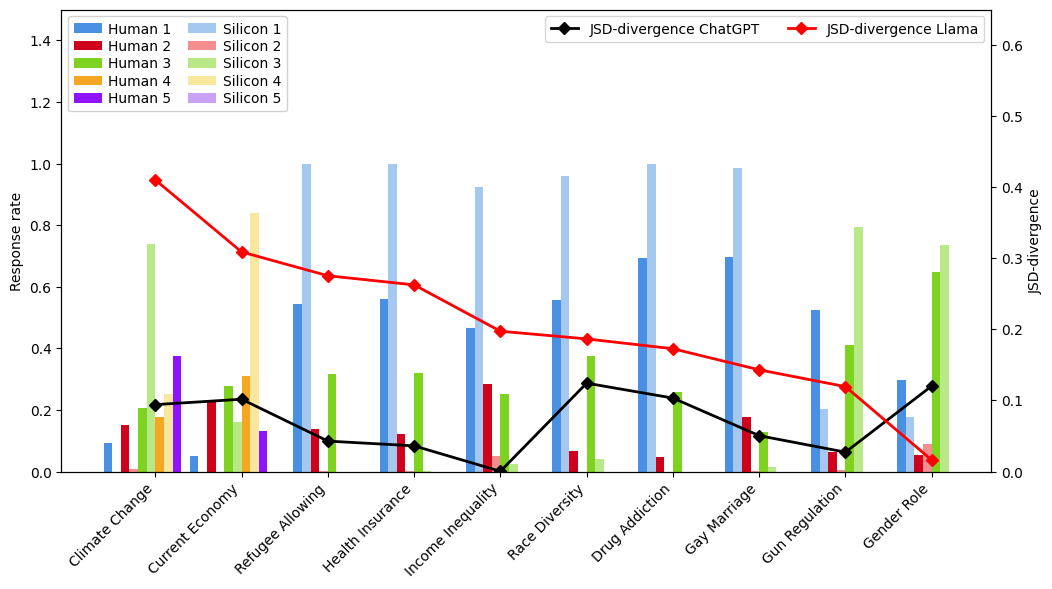

In [ ]:
import matplotlib.pyplot as plt


def plot1(human_results, silicon_results, jsd_results1, jsd_results2):

    categories = [
        'Climate Change', 'Current Economy', 'Refugee Allowing', 'Health Insurance',
        'Income Inequality', 'Race Diversity', 'Drug Addiction',
        'Gay Marriage', 'Gun Regulation', 'Gender Role']

    anes_data = []
    silicon_data = []
    jsd_divergence_1 = []
    jsd_divergence_2 = []

    x = np.arange(len(categories))  

    bar_width = 0.1

    anes_dict = {list(d.keys())[0]: list(d.values())[0] for d in human_results}
    silicon_dict = {list(d.keys())[0]: list(d.values())[0] for d in silicon_results}

    for question in categories: #for each questio create a response distribution in percentages

        anes_responses = anes_dict[question]
        silicon_responses = silicon_dict[question]

        anes_array = np.array([anes_responses.get(k, 0) for k in anes_responses], dtype=float) 
        silicon_array = np.array([silicon_responses.get(k, 0) for k in silicon_responses], dtype=float)

        anes_array /= anes_array.sum()
        silicon_array /= silicon_array.sum()

        anes_data.append(anes_array)
        silicon_data.append(silicon_array)

        jsd_divergence_1.append(jsd_results1[question])
        jsd_divergence_2.append(jsd_results2[question])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    anes_colors = ['#4A90E2', '#D0021B', '#7ED321', '#F5A623', '#9013FE']
    silicon_colors = ['#A4C8F0', '#F58F8F', '#B8E986', '#F8E79C', '#C9A2F7']  

    for cat in range(len(categories)): #add by category
        n_responses = len(anes_data[cat])  
        for i in range(n_responses): #add by answer option
           
            base_pos = cat + (i - n_responses/2) * (2 * bar_width)
            
            
            ax1.bar(base_pos - bar_width/2, anes_data[cat][i],
                    width=bar_width, color=anes_colors[i], label=f'Human {i+1}' if cat == 0 else "")
            
    for cat in range(len(categories)): #add human responses by category
        n_responses = len(anes_data[cat])  
        for i in range(n_responses): #add human responses by answer option
        
            base_pos = cat + (i - n_responses/2) * (2 * bar_width)
    
            # silicon bar (right)
            ax1.bar(base_pos + bar_width/2, silicon_data[cat][i],
                    width=bar_width, color=silicon_colors[i], label=f'Silicon {i+1}' if cat == 0 else "")

    ax1.set_ylabel('Response rate')
    ax1.set_ylim(0, 1.5)
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.legend(loc='upper right', ncol=2)

    ax2 = ax1.twinx()
    ax2.plot(x, jsd_divergence_1, color='black', marker='D', linewidth=2, label='JSD-divergence ChatGPT')
    ax2.plot(x, jsd_divergence_2, color='red', marker='D', linewidth=2, label='JSD-divergence Llama')
    ax2.set_ylabel('JSD-divergence')
    ax2.set_ylim(0, 0.65)

    lines1, labels1 = ax1.get_legend_handles_labels() 
    lines2, labels2 = ax2.get_legend_handles_labels()

    all_labels = labels1 + labels2 
    all_lines = lines1 + lines2

    seen = {} 
    for label, line in zip(all_labels, all_lines): 
        if label not in seen: 
            seen[label] = line
    
    ax1.legend(seen.values(), seen.keys(), loc='upper left', ncol=2)

    ax2.legend(lines2, labels2, loc='upper right', ncol=2)

    leg = ax1.legend(
        loc='upper left',
        ncol=2,
        frameon=True,
        borderpad=0.4,       
        labelspacing=0.25,  
        handletextpad=0.5,   
        columnspacing=1.2,   
    )
    leg.get_frame().set_alpha(0.9)

plot1(human_results, replicate_results, jsd_results_previous_study, jsd_results_replicate)

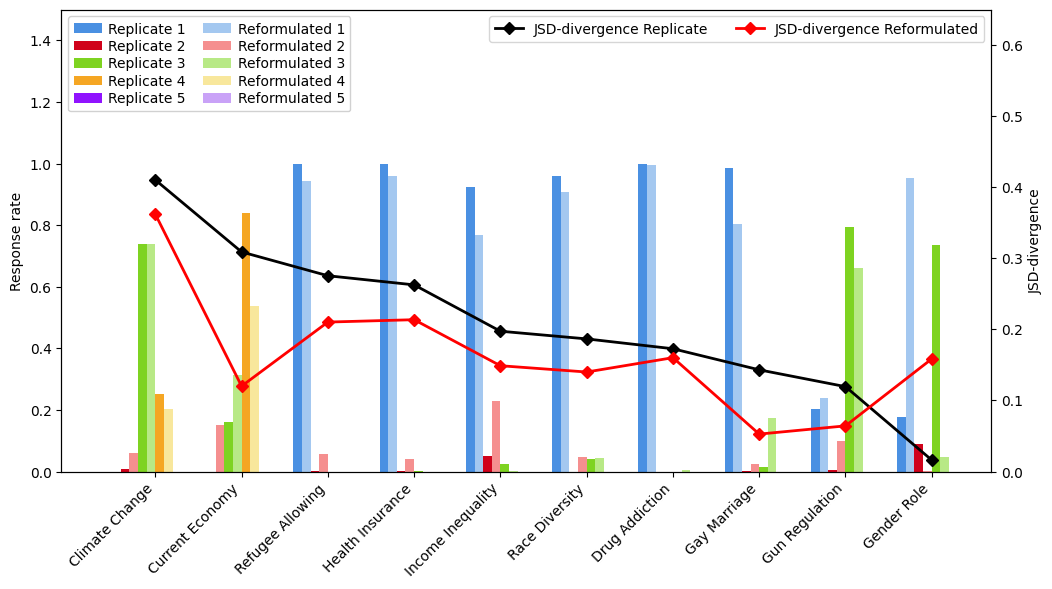

In [ ]:
import matplotlib.pyplot as plt

def plot2(silicon_results_1, silicon_results_2, jsd_results1, jsd_results2, label1, label2):

    categories = [
        'Climate Change', 'Current Economy', 'Refugee Allowing', 'Health Insurance',
        'Income Inequality', 'Race Diversity', 'Drug Addiction',
        'Gay Marriage', 'Gun Regulation', 'Gender Role']

    silicon_data1 = []
    silicon_data2 = []
    jsd_divergence_1 = []
    jsd_divergence_2 = []

    x = np.arange(len(categories))  

    bar_width = 0.1

    silicon_dict1 = {list(d.keys())[0]: list(d.values())[0] for d in silicon_results_1}
    silicon_dict2 = {list(d.keys())[0]: list(d.values())[0] for d in silicon_results_2}

    for question in categories: #for each questio create a response distribution in percentages

        silicon_responses_1 = silicon_dict1[question]
        silicon_responses_2 = silicon_dict2[question]

        silicon_array_1 = np.array([silicon_responses_1.get(k, 0) for k in silicon_responses_1], dtype=float) 
        silicon_array_2 = np.array([silicon_responses_2.get(k, 0) for k in silicon_responses_2], dtype=float)

        silicon_array_1 /= silicon_array_1.sum()
        silicon_array_2 /= silicon_array_2.sum()

        silicon_data1.append(silicon_array_1)
        silicon_data2.append(silicon_array_2)

        jsd_divergence_1.append(jsd_results1[question])
        jsd_divergence_2.append(jsd_results2[question])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Define colors
    silicon_colors_1 = ['#4A90E2', '#D0021B', '#7ED321', '#F5A623', '#9013FE']
    silicon_colors_2 = ['#A4C8F0', '#F58F8F', '#B8E986', '#F8E79C', '#C9A2F7'] 

    for cat in range(len(categories)): #add by category
        n_responses = len(silicon_data1[cat])  
        for i in range(n_responses): #add by answer option
            base_pos = cat + (i - n_responses/2) * (2 * bar_width)
            
            ax1.bar(base_pos - bar_width/2, silicon_data1[cat][i],
                    width=bar_width, color=silicon_colors_1[i], label=(label1 + f' {i+1}') if cat == 0 else "")
            
    for cat in range(len(categories)): #add human responses by category
        n_responses = len(silicon_data1[cat])  
        for i in range(n_responses): #add human responses by answer option
            base_pos = cat + (i - n_responses/2) * (2 * bar_width)
    
            ax1.bar(base_pos + bar_width/2, silicon_data2[cat][i],
                    width=bar_width, color=silicon_colors_2[i], label=(label2 + f' {i+1}') if cat == 0 else "")

    ax1.set_ylabel('Response rate')
    ax1.set_ylim(0, 1.5)
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.legend(loc='upper right', ncol=2)

    ax2 = ax1.twinx()
    ax2.plot(x, jsd_divergence_1, color='black', marker='D', linewidth=2, label='JSD-divergence ' + label1)
    ax2.plot(x, jsd_divergence_2, color='red', marker='D', linewidth=2, label='JSD-divergence ' + label2)
    ax2.set_ylabel('JSD-divergence')
    ax2.set_ylim(0, 0.65)

    lines1, labels1 = ax1.get_legend_handles_labels() 
    lines2, labels2 = ax2.get_legend_handles_labels()

    all_labels = labels1 + labels2 
    all_lines = lines1 + lines2

    seen = {} 
    for label, line in zip(all_labels, all_lines): 
        if label not in seen: 
            seen[label] = line
    
    ax1.legend(seen.values(), seen.keys(), loc='upper left', ncol=2)

    ax2.legend(lines2, labels2, loc='upper right', ncol=2)

    leg = ax1.legend(
        loc='upper left',
        ncol=2,
        frameon=True,
        borderpad=0.4,       
        labelspacing=0.25,   
        handletextpad=0.5,   
        columnspacing=1.2,   
    )
    leg.get_frame().set_alpha(0.9)

plot2(replicate_results, reformulated_3rdP_results, jsd_results_replicate, jsd_results_3rdP_reformulated_GR, 'Replicate', 'Reformulated')

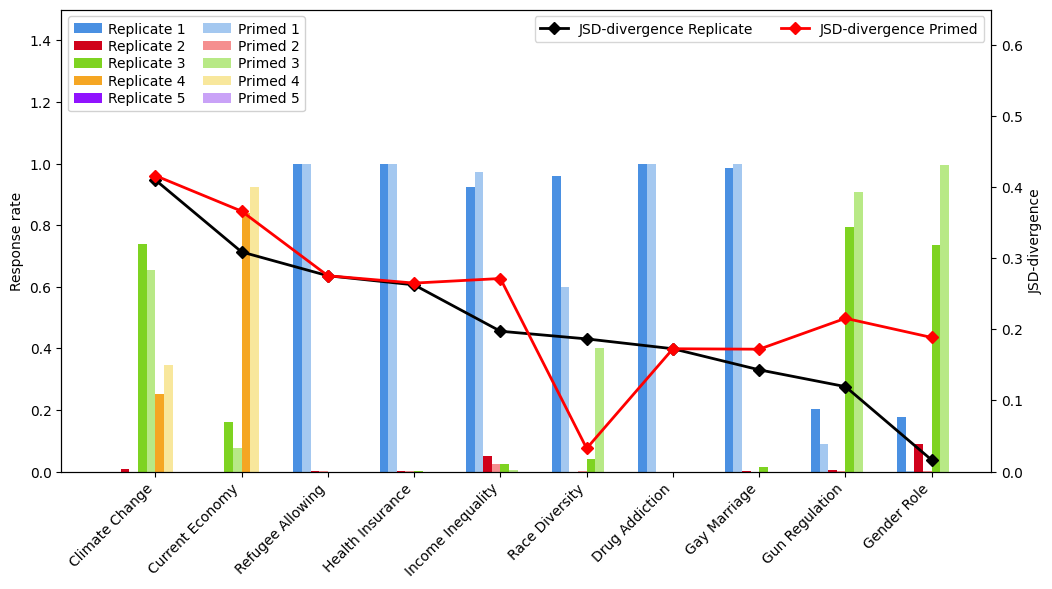

In [53]:
plot2(replicate_results, primed_original_results, jsd_results_replicate, jsd_results_priming_original, 'Replicate', 'Primed')